In [1]:
from mmrely import *
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import stft, windows
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import pickle
import json


In [3]:
train_parameters_list = [
    {
        "radar_altitude": [0, 15],
        "radar_polangle": [[np.pi / 4, 0], [np.pi / 6, np.pi / 12]],  # [radar_alpha, radar_belta]
        "warhead_v": [0, 7.12e3, 1e3],
        "warhead_r": [6771e3, 0, 0],
        "track_interval": [60, 120]
    },
    {
        "radar_altitude": [0, 1e3, 0],
        "radar_polangle": [[np.pi / 6, np.pi / 6], [np.pi / 9, np.pi / 40],  [np.pi / 5, np.pi / 50]],  # [radar_alpha, radar_belta]
        "warhead_v": [0, 6e3, 3e3],
        "warhead_r": [6771e3, 0, 1000e3],
        "track_interval": [60, 140]
    },
    {
        "radar_altitude": [0, 2e3],
        "radar_polangle": [[np.pi / 12, np.pi / 12], [np.pi / 9, -np.pi / 12]],  # [radar_alpha, radar_belta]
        "warhead_v": [0, 6e3, 5e3],
        "warhead_r": [6671e3, 0, -1000e3],
        "track_interval": [60, 90]
    },
    {
        "radar_altitude": [0, 1.5e3],
        "radar_polangle": [[np.pi / 12, np.pi / 12], [np.pi / 9, 0]],  # [radar_alpha, radar_belta]
        "warhead_v": [0, 6e3, -3e3],
        "warhead_r": [6971e3, 1e3, 2000e3],
        "track_interval": [60, 90]
    },
]

test_parameters_list = [
    {
        "radar_altitude": [0],
        "radar_polangle": [[np.pi / 4.5, np.pi / 6]],  # [radar_alpha, radar_belta]
        "warhead_v": [0, 3e3, 1e3],
        "warhead_r": [6771e3, 2000e3, 4000e3],
        "track_interval": [120, 240]
    },
    {
        "radar_altitude": [0],
        "radar_polangle": [[np.pi / 6, np.pi / 6]],  # [radar_alpha, radar_belta]
        "warhead_v": [1e3, 3e3, 5e3],
        "warhead_r": [6571e3, 1000e3, 1000e3],
        "track_interval": [130, 250]
    },
]

# Save the data to a JSON file
with open('parameters.json', 'w') as file:
    json.dump({"train_parameters": train_parameters_list, "test_parameters": test_parameters_list}, file, indent=4)


In [4]:
with open('parameters.json', 'r') as file:
    data = json.load(file)
train_parameters_list = data["train_parameters"]
test_parameters_list = data["test_parameters"]

In [36]:
# train_parameters_list = [
#     {
#         "radar_altitude": ["0", "15"],
#         "radar_polangle": [["np.pi / 4", "0"], ["np.pi / 6", "np.pi / 12"]],  # [radar_alpha, radar_belta]
#         "warhead_v": ["0", "7.12e3", "1e3"],
#         "warhead_r": ["6771e3", "0", "0"],
#         "track_interval": ["60", "120"]
#     },
#     {
#         "radar_altitude": ["0", "1e3", "0"],
#         "radar_polangle": [["np.pi / 6", "np.pi / 6"], ["np.pi / 9", "np.pi / 40"], ["np.pi / 5", "np.pi / 50"]],  # [radar_alpha, radar_belta]
#         "warhead_v": ["0", "6e3", "3e3"],
#         "warhead_r": ["6771e3", "0", "1000e3"],
#         "track_interval": ["60", "140"]
#     },
#     {
#         "radar_altitude": ["0", "2e3"],
#         "radar_polangle": [["np.pi / 12", "np.pi / 12"], ["np.pi / 9", "-np.pi / 12"]],  # [radar_alpha, radar_belta]
#         "warhead_v": ["0", "6e3", "5e3"],
#         "warhead_r": ["6671e3", "0", "-1000e3"],
#         "track_interval": ["60", "90"]
#     },
#     {
#         "radar_altitude": ["0", "1.5e3"],
#         "radar_polangle": [["np.pi / 12", "np.pi / 12"], ["np.pi / 9", "0"]],  # [radar_alpha, radar_belta]
#         "warhead_v": ["0", "6e3", "-3e3"],
#         "warhead_r": ["6971e3", "1e3", "2000e3"],
#         "track_interval": ["60", "90"]
#     },
# ]

# test_parameters_list = [
#     {
#         "radar_altitude": ["0"],
#         "radar_polangle": [["np.pi / 4.5", "np.pi / 6"]],  # [radar_alpha, radar_belta]
#         "warhead_v": ["0", "3e3", "1e3"],
#         "warhead_r": ["6771e3", "2000e3", "4000e3"],
#         "track_interval": ["120", "240"]
#     },
#     {
#         "radar_altitude": ["0"],
#         "radar_polangle": [["np.pi / 6", "np.pi / 6"]],  # [radar_alpha, radar_belta]
#         "warhead_v": ["1e3", "3e3", "5e3"],
#         "warhead_r": ["6571e3", "1000e3", "1000e3"],
#         "track_interval": ["130", "250"]
#     },
# ]

# # Save the data to a JSON file
# with open('parameters.json', 'w') as file:
#     json.dump({"train_parameters": train_parameters_list, "test_parameters": test_parameters_list}, file, indent=4)

In [5]:
def display_track(initial_parameters_list, combine = True, type = 'train'):
    R = 6371e3
    if combine:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for parameters in initial_parameters_list:
            a, e, i, Omega, omega, M0 = orbital_elements(parameters['warhead_r'], parameters['warhead_v'] , False)
            orbit_points, _ = calculate_orbit_points(a, e, i, Omega, omega, M0, 1000)
            view_orbit(ax, parameters['warhead_r'], parameters['warhead_v'], None, 0, 45, 'Warhead Orbit', orbit_points = orbit_points)
            ax.scatter(orbit_points[-1][0], orbit_points[-1][1], orbit_points[-1][2], marker='x', color = 'k')
            ax.scatter(orbit_points[0][0], orbit_points[0][1], orbit_points[0][2], marker='.', color = 'k')
            start_point = orbit_points[parameters['track_interval'][0]]
            end_point = orbit_points[parameters['track_interval'][1]]

            for idx,radar_pa in enumerate(parameters['radar_polangle']):
                r = R + parameters['radar_altitude'][idx]
                radar = np.array([r * np.cos(radar_pa[0]) * np.cos(radar_pa[1]), 
                                    r * np.sin(radar_pa[0]) * np.cos(radar_pa[1]), 
                                    r * np.sin(radar_pa[1])]) 
                ax.scatter(start_point[0], start_point[1], start_point[2], color = 'b', s=5)
                ax.scatter(end_point[0], end_point[1], end_point[2] , color = 'b', s=5)
                
                ax.scatter(radar[0], radar[1], radar[2] , color = 'r', s=5)
                
                vertices = [ start_point, end_point, radar]
                poly3d = [vertices]

                ax.add_collection3d(Poly3DCollection(poly3d, facecolors='gray', linewidths=0.5, edgecolors='b', alpha=0.5))
                
    
    else:
        for num,parameters in enumerate(initial_parameters_list):
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            a, e, i, Omega, omega, M0 = orbital_elements(parameters['warhead_r'], parameters['warhead_v'] , False)
            orbit_points, _ = calculate_orbit_points(a, e, i, Omega, omega, M0, 1000)
            view_orbit(ax, parameters['warhead_r'], parameters['warhead_v'], None, 0, 45, None, orbit_points = orbit_points)
            ax.scatter(orbit_points[-1][0], orbit_points[-1][1], orbit_points[-1][2], marker='x', color = 'k')
            ax.scatter(orbit_points[0][0], orbit_points[0][1], orbit_points[0][2], marker='.', color = 'k')
            start_point = orbit_points[parameters['track_interval'][0]]
            end_point = orbit_points[parameters['track_interval'][1]]

            for idx,radar_pa in enumerate(parameters['radar_polangle']):
                r = R + parameters['radar_altitude'][idx]
                radar = np.array([r * np.cos(radar_pa[0]) * np.cos(radar_pa[1]), 
                                    r * np.sin(radar_pa[0]) * np.cos(radar_pa[1]), 
                                    r * np.sin(radar_pa[1])]) 
                ax.scatter(start_point[0], start_point[1], start_point[2], color = 'b', s=5)
                ax.scatter(end_point[0], end_point[1], end_point[2] , color = 'b', s=5)
                
                ax.scatter(radar[0], radar[1], radar[2] , color = 'r', s=5)
                
                # vertices = [radar, start_point, end_point]
                # poly3d = [vertices]

                # ax.add_collection3d(Poly3DCollection(poly3d, facecolors='gray', linewidths=0.5, edgecolors='b', alpha=0.5))
                verts = orbit_points[parameters['track_interval'][0]:parameters['track_interval'][1]].tolist()
                verts.append(radar.tolist())
                ax.add_collection3d(Poly3DCollection([verts], facecolors='gray', linewidths=0.5, edgecolors='b', alpha=0.5))

                ax.set_axis_off()
            
            fig.savefig(f'./output/{type}_{num}.png', format='png', dpi=500, bbox_inches='tight')
            plt.close(fig)

In [40]:
display_track(train_parameters_list, combine = False, type='train')
display_track(test_parameters_list, combine = False,type='test')

In [11]:
# ------------- Euler angle ------------------------------------------
ang_x_int= -np.pi/2 
ang_y_int= 0
ang_z_int= np.pi
# ------------- cone axis -------------------------------------------
alpha= -np.pi/2
belta= -np.pi/12
# -------------- micro-motion parameters ---------------------------
freq= [0*np.pi, 2*np.pi, 0]
amp_n= 0

In [12]:
mm_parameter_list = [
    {
        'target_name': '1',
        'prec_freq': [2.5,4.5],
        'prec_ang': [4, 5.5],
        'nuta_freq': [1],
        'nuta_ang': [2],
    },
    {
        'target_name': '2',
        'prec_freq': [2,4],
        'prec_ang': [4, 5.5],
        'nuta_freq': [0],
        'nuta_ang': [0], 
    },
    {
        'target_name': '3',
        'prec_freq': [1.5,3.5],
        'prec_ang': [4, 5.5],
        'nuta_freq': [0.5],
        'nuta_ang': [1], 
    },
    {
        'target_name': '4',
        'prec_freq': [1,3],
        'prec_ang': [2, 3.5],
        'nuta_freq': [0],
        'nuta_ang': [0], 
    },
]

def get_mmpara(mm_parameter):   
    belta = np.deg2rad(np.random.uniform(mm_parameter['prec_ang'][0],mm_parameter['prec_ang'][1]))
    freq = [0, np.random.uniform(mm_parameter['prec_freq'][0],mm_parameter['prec_freq'][1])*2*np.pi , mm_parameter['nuta_freq'][0]*2*np.pi]
    amp_n = np.deg2rad(mm_parameter['nuta_ang'][0])
    return belta, freq, amp_n

In [102]:
# extract los from orbit.
R = 6371e3
mu=3.986e14

for target_idx in range(4):
# target_idx = 0   # 0-3 4 types of orbit.
    los_list = []

    for x,parameters in enumerate(train_parameters_list):
        a, e, i, Omega, omega, M0 = orbital_elements(parameters['warhead_r'], parameters['warhead_v'] , False)
        orbit_points, M_points = calculate_orbit_points(a, e, i, Omega, omega, M0, 1000)
        T = 2 * np.pi * np.sqrt(a**3 / mu)

        t_start  = (M_points[parameters['track_interval'][0]]*T)/(2*np.pi)
        t_end = (M_points[parameters['track_interval'][1]]*T)/(2*np.pi)

        for idx,radar_pa in enumerate(parameters['radar_polangle']):
            r = R + parameters['radar_altitude'][idx]
            radar = np.array([r * np.cos(radar_pa[0]) * np.cos(radar_pa[1]), 
                            r * np.sin(radar_pa[0]) * np.cos(radar_pa[1]), 
                            r * np.sin(radar_pa[1])])  

            # size: How many instances of each target.
            ob_list = np.random.uniform(t_start, t_end-2, size = 700)
            for start_ob in ob_list:
                ob_M = start_ob*(2*np.pi)/T
                belta, freq, amp_n = get_mmpara(mm_parameter_list[target_idx])

                # point_num: sample frequency
                _, los_deg, radar_warhead = get_los(ang_x_int, ang_y_int, ang_z_int, alpha, belta, freq , amp_n,
                                    T= 2,  point_num= 2048, start_position= ob_M,
                                    a= a, e= e, Omega= Omega, i= i, omega= omega, radar_position= radar,   
                                    random_phase= True)
                data = {
                    'LOS': los_deg,
                    'Radar_warhead': radar_warhead,
                    'Orbit_ID': x,
                    'Radar_ID': idx,
                    'Radar_position': radar.tolist(),
                    'Target_ID': target_idx 
                }
                los_list.append(data)
                break                          #
        break
            
    with open('los_list_' + str(target_idx) + '.pkl', 'wb') as file:
        pickle.dump(los_list, file)

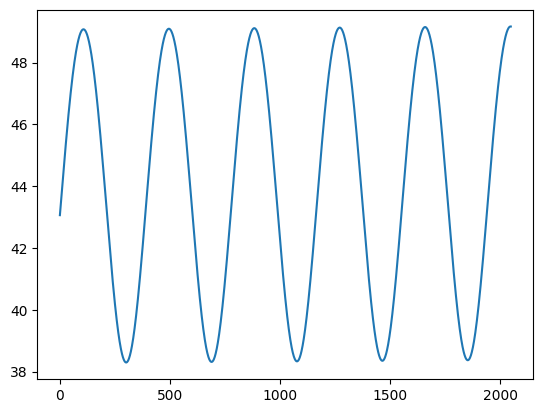

In [103]:
a = pickle.load(open('los_list_1.pkl', 'rb'))
plt.plot(a[0]['LOS'])

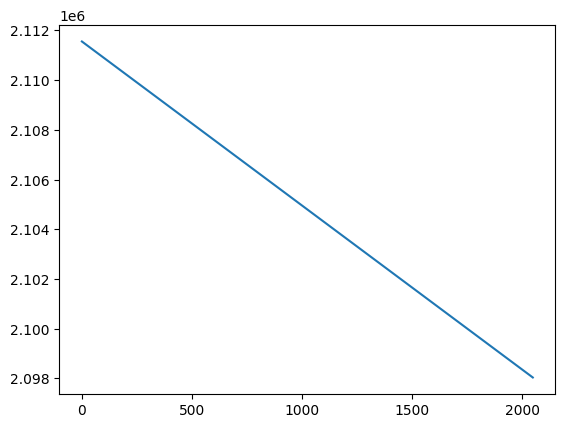

In [104]:
R = [np.linalg.norm(i) for i in a[0]['Radar_warhead']]
plt.plot(R)

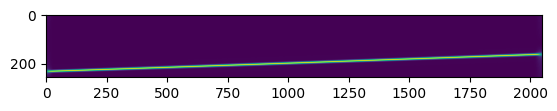

In [ ]:
def STFT(st):
    winlen = 64
    _, _, Zxx = stft(st, fs=256, window = windows.hamming(winlen),nperseg=winlen, nfft=256, noverlap=winlen-1,boundary='zeros',return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0)

t = np.linspace(0, 2, 2048)
c = 3e8
dt = t[1] - t[0]

fc = 10e9

# 计算径向速度 v_r
v_r = np.diff(R) / dt
v_r = np.append(v_r, v_r[-1])  # 补齐数组长度

# 计算多普勒频移 f_d
lambda_ = c / fc
f_d = 2 * v_r / lambda_

s_baseband = np.exp(-1j * 2 * np.pi * f_d * t)

tf = STFT(s_baseband)
plt.imshow(np.abs(tf))

In [80]:
td

array([0.01367141, 0.01367137, 0.01367134, ..., 0.01359867, 0.01359864,
       0.0135986 ])

In [11]:
# # extract los from orbit.
# R = 6371e3
# mu=3.986e14

# for target_idx in range(4):
# # target_idx = 0   # 0-3 4 types of orbit.
#     los_list = []

#     for x,parameters in enumerate(test_parameters_list):
#         a, e, i, Omega, omega, M0 = orbital_elements(parameters['warhead_r'], parameters['warhead_v'] , False)
#         orbit_points, M_points = calculate_orbit_points(a, e, i, Omega, omega, M0, 1000)
#         T = 2 * np.pi * np.sqrt(a**3 / mu)

#         t_start  = (M_points[parameters['track_interval'][0]]*T)/(2*np.pi)
#         t_end = (M_points[parameters['track_interval'][1]]*T)/(2*np.pi)

#         for idx,radar_pa in enumerate(parameters['radar_polangle']):
#             r = R + parameters['radar_altitude'][idx]
#             radar = np.array([r * np.cos(radar_pa[0]) * np.cos(radar_pa[1]), 
#                             r * np.sin(radar_pa[0]) * np.cos(radar_pa[1]), 
#                             r * np.sin(radar_pa[1])])  

#             # size: How many instances of each target.
#             ob_list = np.random.uniform(t_start, t_end-2, size = 700)
#             for start_ob in ob_list:
#                 ob_M = start_ob*(2*np.pi)/T
#                 belta, freq, amp_n = get_mmpara(mm_parameter_list[target_idx])

#                 # point_num: sample frequency
#                 _, los_deg = get_los(ang_x_int, ang_y_int, ang_z_int, alpha, belta, freq , amp_n,
#                                     T= 2,  point_num= 2048, start_position= ob_M,
#                                     a= a, e= e, Omega= Omega, i= i, omega= omega, radar_position= radar,   
#                                     random_phase= True)
#                 data = {
#                     'LOS': los_deg,
#                     'Orbit_ID': x,
#                     'Radar_ID': idx,
#                     'Target_ID': target_idx 
#                 }
#                 los_list.append(data)
            
#     with open('los_list_test_' + str(target_idx) + '.pkl', 'wb') as file:
#         pickle.dump(los_list, file)